<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#多项式拟合中的方差和偏差数值实验研究" data-toc-modified-id="多项式拟合中的方差和偏差数值实验研究-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>多项式拟合中的方差和偏差数值实验研究</a></span></li><li><span><a href="#单次拟合" data-toc-modified-id="单次拟合-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>单次拟合</a></span></li><li><span><a href="#偏差和方差示意图" data-toc-modified-id="偏差和方差示意图-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>偏差和方差示意图</a></span></li><li><span><a href="#多项式次数对偏差和方差的影响" data-toc-modified-id="多项式次数对偏差和方差的影响-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>多项式次数对偏差和方差的影响</a></span><ul class="toc-item"><li><span><a href="#偏差方差示意图" data-toc-modified-id="偏差方差示意图-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>偏差方差示意图</a></span></li><li><span><a href="#多项式次数对偏差和方差的影响" data-toc-modified-id="多项式次数对偏差和方差的影响-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>多项式次数对偏差和方差的影响</a></span></li><li><span><a href="#附注" data-toc-modified-id="附注-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>附注</a></span></li></ul></li><li><span><a href="#正则化参数对偏差和方差的影响" data-toc-modified-id="正则化参数对偏差和方差的影响-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>正则化参数对偏差和方差的影响</a></span><ul class="toc-item"><li><span><a href="#偏差和方差示意图" data-toc-modified-id="偏差和方差示意图-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>偏差和方差示意图</a></span></li><li><span><a href="#正则化参数对偏差和方差的影响" data-toc-modified-id="正则化参数对偏差和方差的影响-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>正则化参数对偏差和方差的影响</a></span></li><li><span><a href="#正则化参数对参数的影响" data-toc-modified-id="正则化参数对参数的影响-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>正则化参数对参数的影响</a></span></li></ul></li></ul></div>

# 多项式拟合中的方差和偏差数值实验研究

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures


#np.random.seed(2)
np.random.seed(3)
N_TRAIN=20
SIGMA=1E-1
PN = 4


# generate weight
w = 2*np.random.rand(PN+1)-1
w[3] = -1
w[4] = 0.5
print("P(x) = ", end = "")
for i, w_ in enumerate(w):
    if i == 0:
        print("%+.5f"%(w_), end=" ")
    else:
        print("%+.5f x^%d"%(w_, i), end=" ")
print()

# truth model
def get_y_truth(X):
    X = X.reshape(-1)
    Xn = np.array([np.power(X, i) for i in range(0, PN+1)])
    y = np.sum(Xn*w[:,np.newaxis], axis=0)
    return y
    
# y truth plus random noise
def get_y(X):
    y = get_y_truth(X)
    y = y + SIGMA*np.random.randn(y.shape[0])
    return y


# generate X and y
def generate(n, X_train=None):
    if X_train is None:
        X_train=2*np.random.rand(n, 1) - 1
        y_train = get_y(X_train)
        return X_train, y_train
    else:
        y_train = get_y(X_train)
        return X_train, y_train



class AvgReg:
    
    def __init__(self, n, alpha, tol=None):
        self.n = n
        self.alpha = alpha
        self.tol = tol
        self.intercepts = []
        self.coefs = []
        self.pre = None
    
    def train(self, X_train, y_train):
        n = self.n
        alpha = self.alpha
        
        #print("xtrain", X_train)
        if n >= 2 and self.pre is None:
            self.pre = PolynomialFeatures(n)
            self.pre.fit(X_train)
            
        if self.pre is not None:
            X_train = self.pre.transform(X_train)
        #print("xtrain", X_train)

        if self.tol is None:
            reg = Ridge(alpha = alpha)
        else:
            reg = Ridge(alpha = alpha, tol = self.tol)


        #reg = Lasso(alpha=alpha)
        reg.fit(X_train, y_train)
        self.intercepts.append(reg.intercept_)
        self.coefs.append(reg.coef_)
        
    # average predict
    def predict(self, X, i = -1):
        n = self.n
        if i < 0:
            intercept = np.array(self.intercepts).mean()
            coefs = np.array(self.coefs).mean(axis=0)
        else:
            intercept = self.intercepts[i]
            coefs = self.coefs[i]
            
        
        #print(self.intercepts)
        #print(self.coefs)
        #print(intercept)
        #print(coefs)
        #print(X)
        #print([coefs[i-1]*np.power(X, i) for i in range(1, n)])
        X = X.reshape(-1)
        y = np.array([coefs[i]*np.power(X, i) for i in range(1, n+1)]).sum(axis=0) + intercept
        #print("y:", y)
        return y        

        
    def bias(self, X_test, y_test):
        yhat_test = self.predict(X_test)
        #print(yhat_test)
        #print(y_test)
        return np.sqrt(np.square(yhat_test - y_test).mean())
        
    def stddev(self, X_test):
        n = self.n
        X_test = X_test.reshape(-1)

        coefs = np.array(self.coefs)
        intercepts = np.array(self.intercepts)

        
        t = np.array([coefs[:,i][:,np.newaxis] * np.power(X_test, i) for i in range(1, n+1)])
        #t[ci, train, test data point]
        t = t.sum(axis=0) + intercepts[:, np.newaxis]
        #t[train, test data point]
        
        
        return np.sqrt(np.var(t, axis=0).mean())

    def bias_stddev(self, X_test, y_test):
        n = self.n
        X_test = X_test.reshape(-1)

        coefs = np.array(self.coefs)
        intercepts = np.array(self.intercepts)

        
        t = np.array([coefs[:,i][:,np.newaxis] * np.power(X_test, i) for i in range(1, n+1)])
        #t[ci, train, test data point]
        t = t.sum(axis=0) + intercepts[:, np.newaxis]
        #t[train, test data point]
        
        #print("t", t)
        #print("y", y_test)
        #print(t - y_test)
        return np.sqrt(np.square(t - y_test).mean())

P(x) = +0.10160 +0.41630 x^1 -0.41819 x^2 -1.00000 x^3 +0.50000 x^4 


# 单次拟合

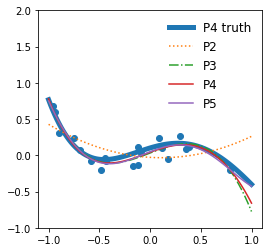

In [2]:
X_train, y_train = generate(N_TRAIN)
ar2 = AvgReg(2, 0)
ar3 = AvgReg(3, 0)
ar4 = AvgReg(4, 0)
ar5 = AvgReg(5, 0)
ar2.train(X_train, y_train)
ar3.train(X_train, y_train)
ar4.train(X_train, y_train)
ar5.train(X_train, y_train)

fig = plt.figure(figsize=(4,4))
X_plt = np.linspace(-1,1,100).reshape(-1,1)
plt.plot(X_plt, get_y_truth(X_plt), label="P%d truth"%PN, linewidth=5)
plt.plot(X_plt, ar2.predict(X_plt, 0), label="P2", linestyle=":")
plt.plot(X_plt, ar3.predict(X_plt, 0), label="P3", linestyle="-.")
plt.plot(X_plt, ar4.predict(X_plt, 0), label="P4")
plt.plot(X_plt, ar5.predict(X_plt, 0), label="P5")

plt.scatter(X_train, y_train)
plt.ylim((-1, 2.0))
plt.legend(frameon=False, fontsize="large", loc="upper right")
plt.show()

# 偏差和方差示意图
对于二次多项式，正则化参数为0。

定义
* 红色虚线代表一个训练集的预测。
* 红色实线代表训练集集合（即无数假想的训练集）的预测的期望。
* 蓝色实线代表真值。

方差与偏差
* 红色实线与蓝色实线的差别称为偏差。
* 红色虚线与红色实线的差别称为方差。


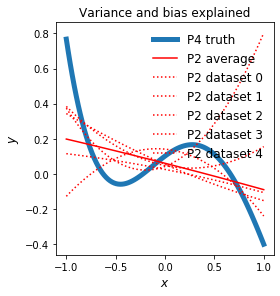

In [3]:
N_DATASETS=2000

def generate_datasets(N_datasets=N_DATASETS, N_train=N_TRAIN, keepX=False):
    datasets=[]    
    X_train=None
    for i in range(N_datasets):
        if keepX:
            X_train, y_train = generate(N_train, X_train=X_train)
        else:
            X_train, y_train = generate(N_train, X_train=None)

        datasets.append((X_train, y_train))
    return datasets




datasets = generate_datasets(N_datasets=N_DATASETS, N_train=N_TRAIN)

ar2 = AvgReg(2, 0)    
for X_train, y_train in datasets:
    ar2.train(X_train, y_train)

fig = plt.figure(figsize=(4,4))
X_plt = np.linspace(-1,1,100).reshape(-1,1)

plt.plot(X_plt, get_y_truth(X_plt), label="P4 truth", linewidth=5)
plt.plot(X_plt, ar2.predict(X_plt), label="P2 average", linestyle="-", color="red")
for i in range(5):
    plt.plot(X_plt, ar2.predict(X_plt, i), label="P2 dataset %d"%i, color="red", linestyle=":")

plt.legend(loc="upper right", fontsize="large", frameon=False)
plt.xlabel("$x$", fontsize="large")
plt.ylabel("$y$", fontsize="large")
plt.tight_layout()
plt.title("Variance and bias explained", fontsize="large")
plt.show()


# 多项式次数对偏差和方差的影响

正则化参数设为0。观察拟合的多项式的次数对拟合结果的偏差和方差的影响。

## 偏差方差示意图

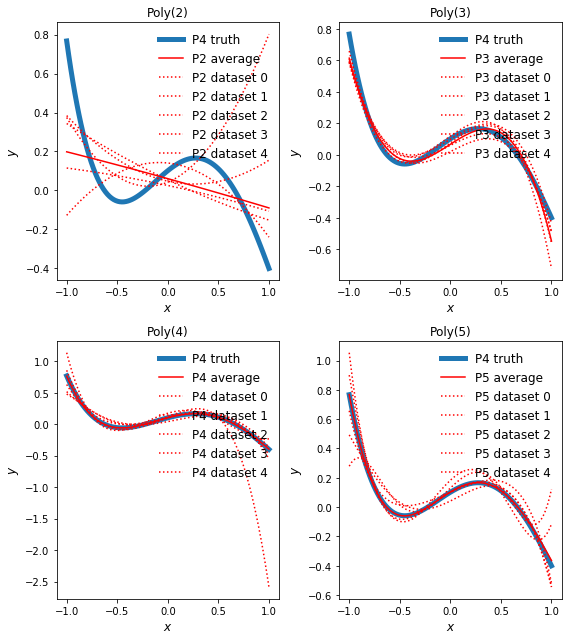

In [4]:
alpha=0
fig, axes = plt.subplots(2, 2, figsize=(8, 9))
for sub, polyN in enumerate([2,3,4,5]):
    
    plt.sca(axes[sub//2][sub%2])
    ar4 = AvgReg(polyN, alpha=alpha)    
    for X_train, y_train in datasets:
        ar4.train(X_train, y_train)

    X_plt = np.linspace(-1,1,100).reshape(-1,1)

    plt.plot(X_plt, get_y_truth(X_plt), label="P4 truth", linewidth=5)
    plt.plot(X_plt, ar4.predict(X_plt), label="P%d average"%polyN, linestyle="-", color="red")
    for i in range(5):
        plt.plot(X_plt, ar4.predict(X_plt, i), label="P%d dataset %d"%(polyN, i), color="red", linestyle=":")

    plt.legend(loc="upper right", fontsize="large", frameon=False)
    plt.xlabel("$x$", fontsize="large")
    plt.ylabel("$y$", fontsize="large")
    plt.title(r"Poly(%d)"%polyN, fontsize="large")
    
plt.tight_layout()
plt.show()

## 多项式次数对偏差和方差的影响

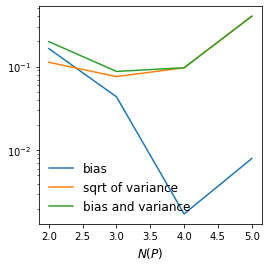

In [5]:
ars = [AvgReg(n, 0.) for n in range(2, 6)]

for ar in ars:
    for X_train, y_train in datasets:
        ar.train(X_train, y_train)

plt.figure(figsize=(4,4))
y_plt_truth = get_y_truth(X_plt)
plt.plot([2,3,4,5], [ar.bias(X_plt, y_plt_truth) for ar in ars], label="bias")
plt.plot([2,3,4,5], [ar.stddev(X_plt) for ar in ars], label="sqrt of variance")
plt.plot([2,3,4,5], [ar.bias_stddev(X_plt, y_plt_truth) for ar in ars], label=r"bias and variance")

plt.xlabel("$N(P)$", fontsize="large")
plt.yscale("log")
plt.legend(loc="best", fontsize="large", frameon=False)
plt.show()


## 附注

在线性回归部分我们证明过
$$
\sqrt{\overline{\text{Var}(y)}}  = \sigma_\epsilon \sqrt{\frac{df}{N} }
$$

其中$\text{df}=N(P)+1$只有当测试数据和训练数据的$X$的协方差矩阵接近时上式成立，我们只需要增加训练数据的数据量便可以演示这一点。

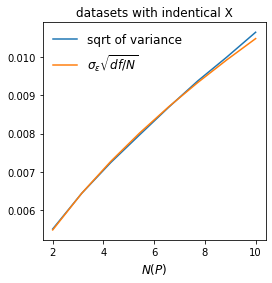

In [6]:
datasets_ = generate_datasets(N_datasets=N_DATASETS, N_train=1000, keepX=True)
ars = [AvgReg(n, 0., tol=1E-6) for n in range(2, 10)]
NPoly = np.linspace(2, 10, 8) 

for ar in ars:
    for X_train, y_train in datasets_:
        ar.train(X_train, y_train)

plt.figure(figsize=(4,4))
y_plt_truth = get_y_truth(X_plt)   
variance = np.array([ar.stddev(X_plt) for ar in ars])
plt.plot(NPoly, variance, label="sqrt of variance")

plt.plot(NPoly,   SIGMA*np.sqrt((NPoly+1)/1000), label=r"$\sigma_\epsilon\sqrt{df/N}$")

plt.xlabel("$N(P)$", fontsize="large")
plt.legend(loc="best", fontsize="large", frameon=False)
plt.title("datasets with indentical X")
plt.show()

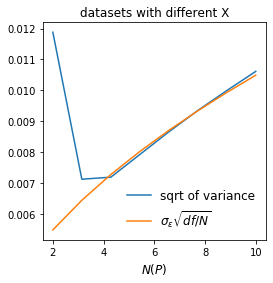

In [7]:
datasets_ = generate_datasets(N_datasets=N_DATASETS, N_train=1000, keepX=False)
ars = [AvgReg(n, 0., tol=1E-6) for n in range(2, 10)]
NPoly = np.linspace(2, 10, 8) 

for ar in ars:
    for X_train, y_train in datasets_:
        ar.train(X_train, y_train)

plt.figure(figsize=(4,4))
y_plt_truth = get_y_truth(X_plt)   
variance = np.array([ar.stddev(X_plt) for ar in ars])
plt.plot(NPoly, variance, label="sqrt of variance")

plt.plot(NPoly,   SIGMA*np.sqrt((NPoly+1)/1000), label=r"$\sigma_\epsilon\sqrt{df/N}$")

plt.xlabel("$N(P)$", fontsize="large")
plt.legend(loc="best", fontsize="large", frameon=False)
plt.title("datasets with different X")
plt.show()

# 正则化参数对偏差和方差的影响

## 偏差和方差示意图

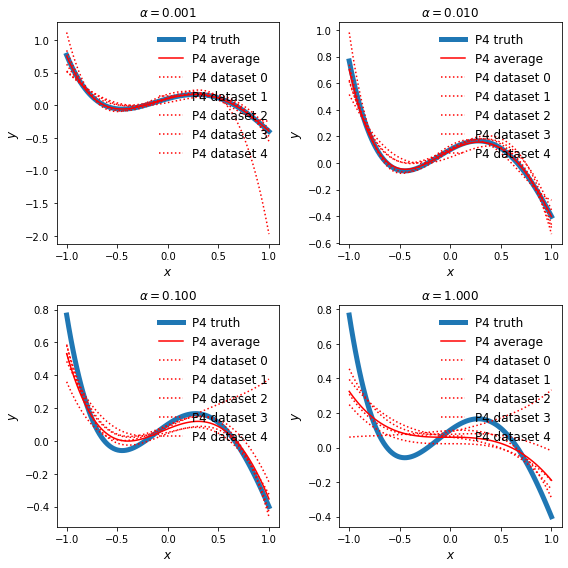

In [8]:
polyN=4
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
for sub, alpha in enumerate([1E-3, 1E-2, 1E-1, 1]):
    
    plt.sca(axes[sub//2][sub%2])
    ar4 = AvgReg(polyN, alpha)    
    for X_train, y_train in datasets:
        ar4.train(X_train, y_train)

    X_plt = np.linspace(-1,1,100).reshape(-1,1)

    plt.plot(X_plt, get_y_truth(X_plt), label="P4 truth", linewidth=5)
    plt.plot(X_plt, ar4.predict(X_plt), label="P%d average"%polyN, linestyle="-", color="red")
    for i in range(5):
        plt.plot(X_plt, ar4.predict(X_plt, i), label="P%d dataset %d"%(polyN, i), color="red", linestyle=":")

    plt.legend(loc="upper right", fontsize="large", frameon=False)
    plt.xlabel("$x$", fontsize="large")
    plt.ylabel("$y$", fontsize="large")
    plt.title(r"$\alpha = %.3f$"%alpha, fontsize="large")
    
plt.tight_layout()
plt.show()

## 正则化参数对偏差和方差的影响

In [9]:
bias_ = []
stddev_ = []
bias_stddev_ = []
cs_=[]

for sub in range(0, 4):
    
    polyN=sub+2
    ars = [AvgReg(polyN, np.power(10, pw)) for pw in np.linspace(-3, 0, 10)]

    for ar in ars:
        for X_train, y_train in datasets:
            ar.train(X_train, y_train)

    
    bias = [ar.bias(X_plt, y_plt_truth) for ar in ars]
    stddev = [ar.stddev(X_plt) for ar in ars]
    bias_stddev = [ar.bias_stddev(X_plt, y_plt_truth) for ar in ars]
    alphas = [ar.alpha for ar in ars]
    cs = [np.array(ar.coefs).mean(axis=0) for ar in ars]
    
    bias_.append(bias)
    stddev_.append(stddev)
    bias_stddev_.append(bias_stddev)
    cs_.append(np.array(cs))
    

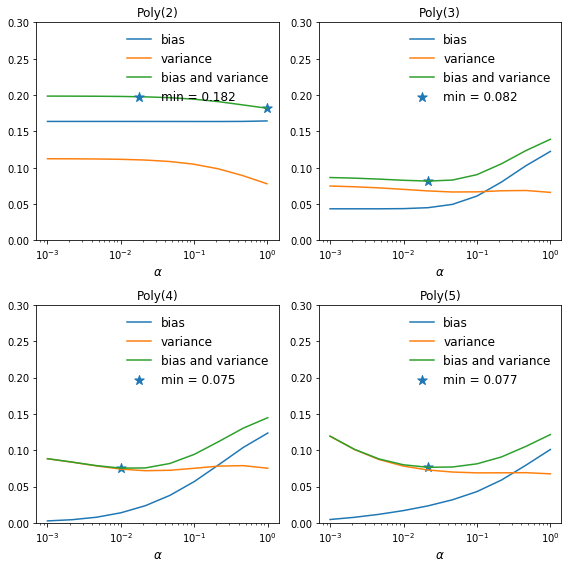

In [10]:
fig, axes = plt.subplots(2,2, figsize=(8,8))

for sub in range(0, 4):

    polyN=sub+2
    plt.sca(axes[sub//2][sub%2])
    
    bias_stddev = bias_stddev_[sub]
    alphas = [ar.alpha for ar in ars]
        
    plt.plot(alphas, bias_[sub], label="bias")
    plt.plot(alphas, stddev_[sub], label="variance")
    plt.plot(alphas, bias_stddev, label=r"bias and variance")
    plt.scatter([ alphas[np.argmin(bias_stddev)] ], [np.min(bias_stddev)], s=100, marker="*", label="min = %.3f"%np.min(bias_stddev))

    plt.ylim((0, 0.3))
    plt.title("Poly(%d)"%polyN, fontsize="large")
    plt.xlabel(r"$\alpha$", fontsize="large")
    #plt.ylabel("")
    #plt.yscale("log")
    plt.xscale("log")
    plt.legend(loc="best", fontsize="large", frameon=False)
    
plt.tight_layout()
plt.show()

## 正则化参数对参数的影响

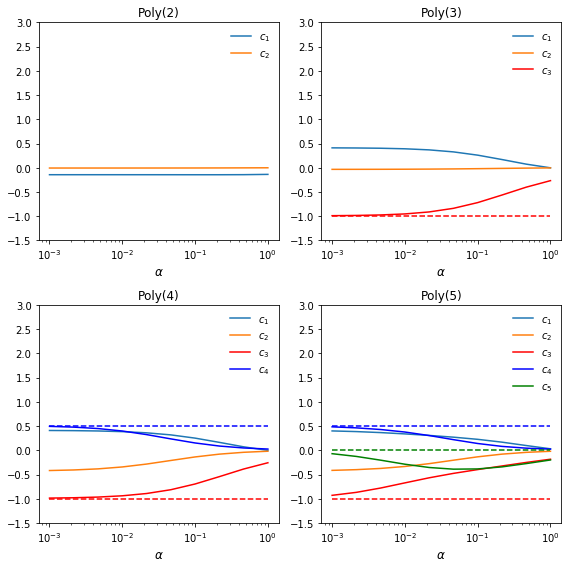

In [11]:
fig, axes = plt.subplots(2,2, figsize=(8,8))

for sub in range(0, 4):

    polyN=sub+2
    plt.sca(axes[sub//2][sub%2])
    
    alphas = [ar.alpha for ar in ars]
    
    plt.plot(alphas, cs_[sub][:,1], label="$c_1$")
    plt.plot(alphas, cs_[sub][:,2], label="$c_2$")
    if polyN >=3:
        plt.plot(alphas, cs_[sub][:,3], label="$c_3$", color="red")
        plt.plot(alphas, np.full(len(alphas), w[3]), color="red", linestyle="--")
    if polyN >=4:
        plt.plot(alphas, cs_[sub][:,4], label="$c_4$", color="blue")
        plt.plot(alphas, np.full(len(alphas), w[4]), color="blue", linestyle="--")
    if polyN >=5:
        plt.plot(alphas, cs_[sub][:,5], label="$c_5$", color="green")
        plt.plot(alphas, np.full(len(alphas), 0), color="green", linestyle="--")
        

    plt.ylim((-1.5,3))
    plt.title("Poly(%d)"%polyN, fontsize="large")
    plt.xlabel(r"$\alpha$", fontsize="large")
    #plt.ylabel("")
    #plt.yscale("log")
    plt.xscale("log")
    plt.legend(loc="upper right", frameon=False)
    
plt.tight_layout()
plt.show()